<a href="https://colab.research.google.com/github/rubyclaguna/DS-Unit-2-Regression-Classification/blob/master/Copy_of_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

     |████████████████████████████████| 92kB 3.6MB/s 
     |████████████████████████████████| 133kB 9.0MB/s 
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
     |████████████████████████████████| 614kB 47.3MB/s 
     |████████████████████████████████| 225kB 47.3MB/s 
     |████████████████████████████████| 768kB 42.6MB/s 
     |████████████████████████████████| 51kB 22.3MB/s 
     |████████████████████████████████| 194kB 53.0MB/s 
     |████████████████████████████████| 51kB 16.2MB/s 
     |████████████████████████████████| 737kB 50.0MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=8aa74129c58092f7feb6c5175e657675fdf9ada90f89a4eaa7e9614bc113da08
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=0bbf520935e2ca4bf0f2a594f1f17b014b566b176

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23040 entries, 0 to 23039
Data columns (total 21 columns):
BOROUGH                           23040 non-null int64
NEIGHBORHOOD                      23040 non-null object
BUILDING_CLASS_CATEGORY           23040 non-null object
TAX_CLASS_AT_PRESENT              23039 non-null object
BLOCK                             23040 non-null int64
LOT                               23040 non-null int64
EASE-MENT                         0 non-null float64
BUILDING_CLASS_AT_PRESENT         23039 non-null object
ADDRESS                           23040 non-null object
APARTMENT_NUMBER                  5201 non-null object
ZIP_CODE                          23039 non-null float64
RESIDENTIAL_UNITS                 23039 non-null float64
COMMERCIAL_UNITS                  23039 non-null float64
TOTAL_UNITS                       23039 non-null float64
LAND_SQUARE_FEET                  22987 non-null object
GROSS_SQUARE_FEET                 23039 non-null float

In [0]:
df.shape

(23040, 21)

In [0]:
# Make a mask where data is true 
mask = ((df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &
        (df['SALE_PRICE'] > 100000) &
        (df['SALE_PRICE'] < 2000000)) 

df = df[mask]

In [0]:
# Convert to datetime
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format = True)
df['SALE_DATE'].describe()

count                    3151
unique                     91
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [0]:
# Split data : Jan-March, April+
train = df[df.SALE_DATE.dt.month < 4]
test = df[df.SALE_DATE.dt.month == 4]

train.shape, test.shape

((2507, 21), (644, 21))

In [0]:
train.select_dtypes('number').columns

Index(['BOROUGH', 'BLOCK', 'LOT', 'EASE-MENT', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE'],
      dtype='object')

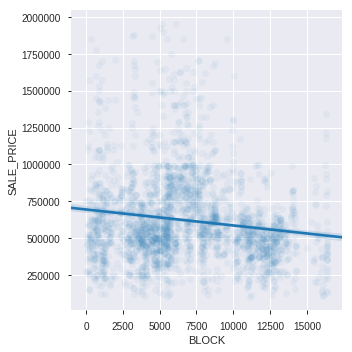

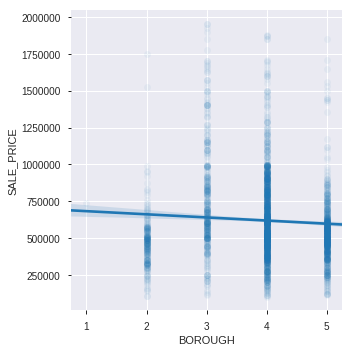

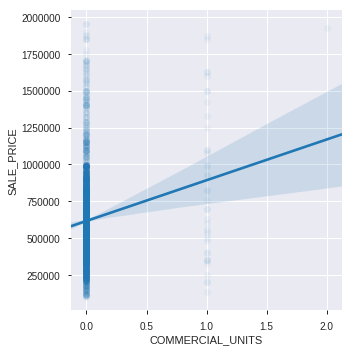

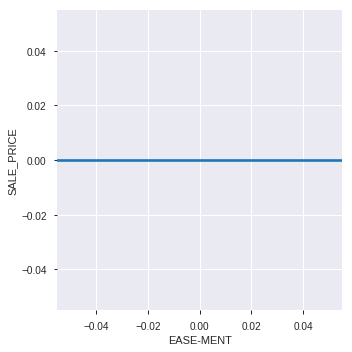

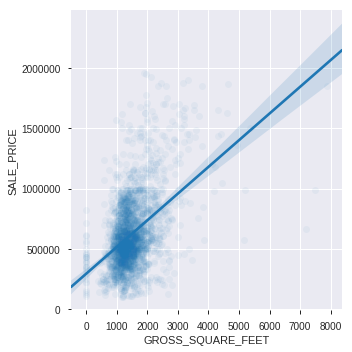

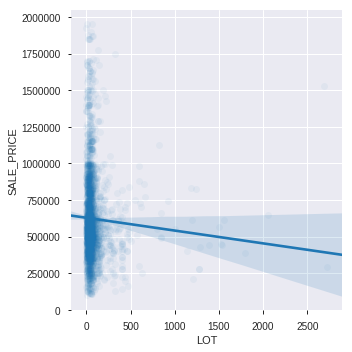

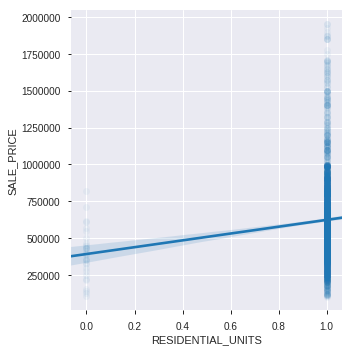

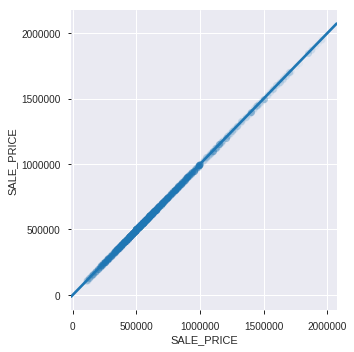

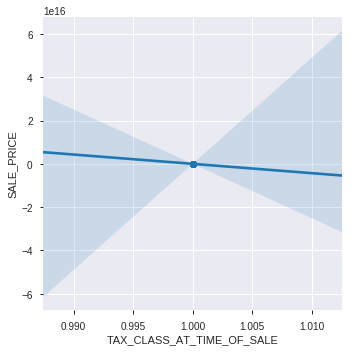

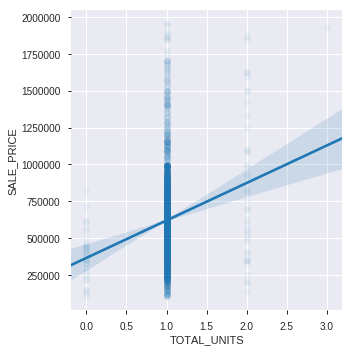

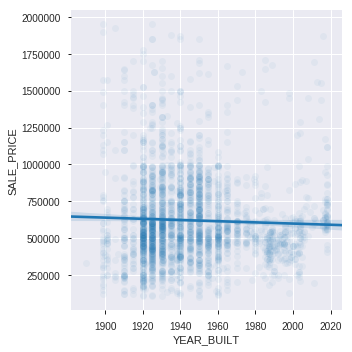

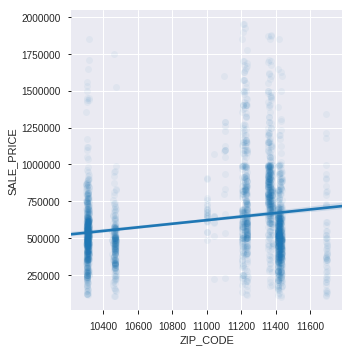

In [0]:
# Explore Data1
import seaborn as sns 
import matplotlib.pyplot as plt
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.05))
    plt.show()

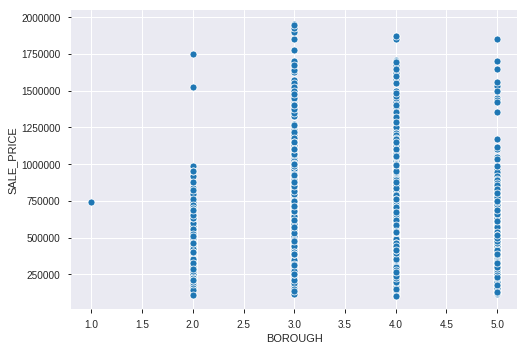

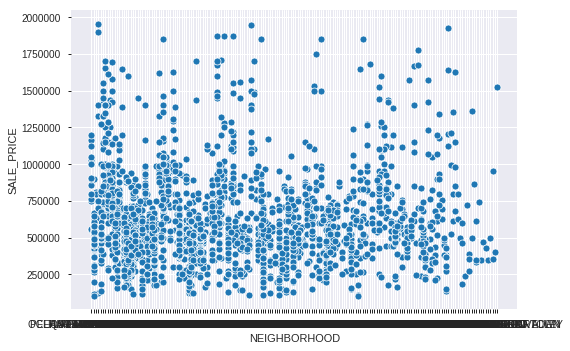

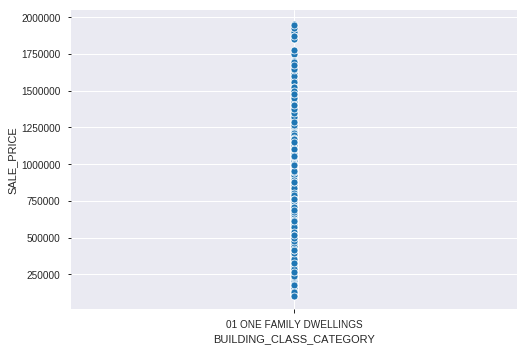

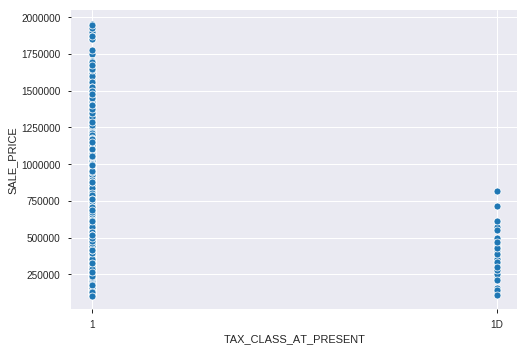

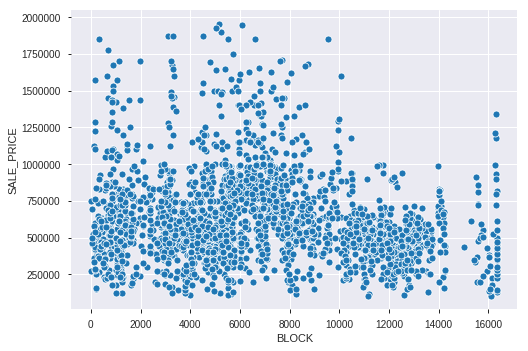

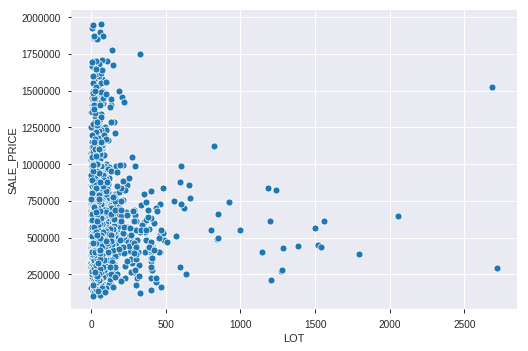

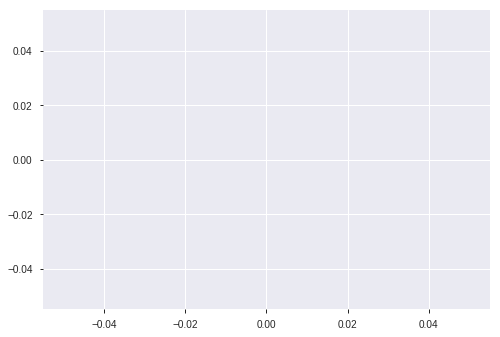

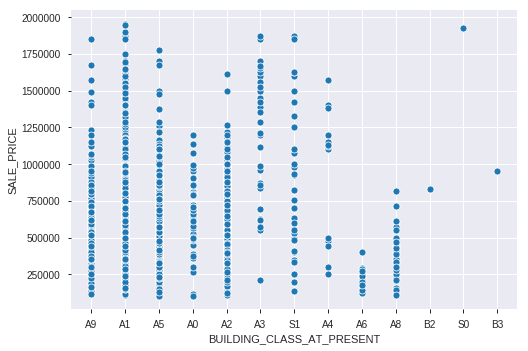

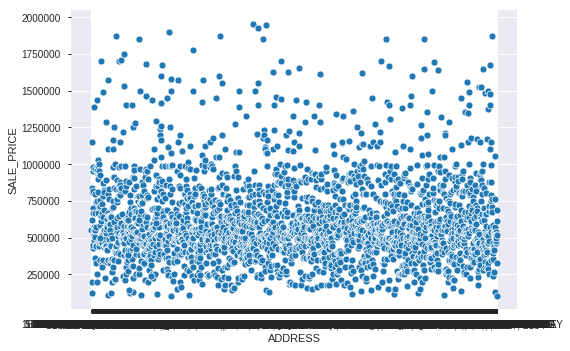

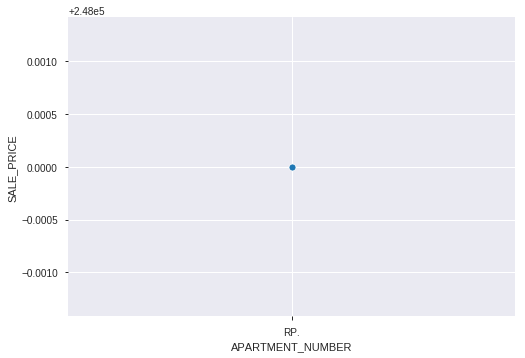

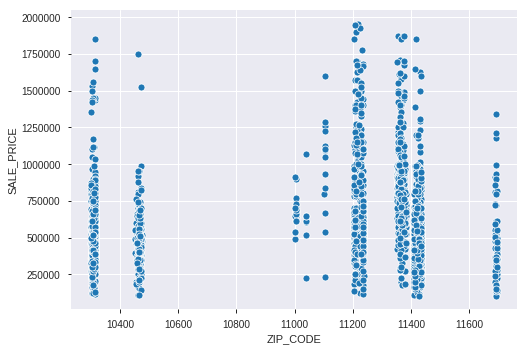

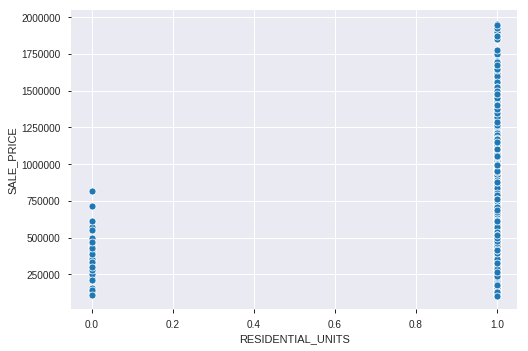

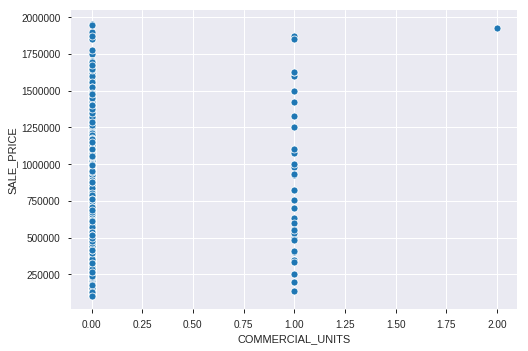

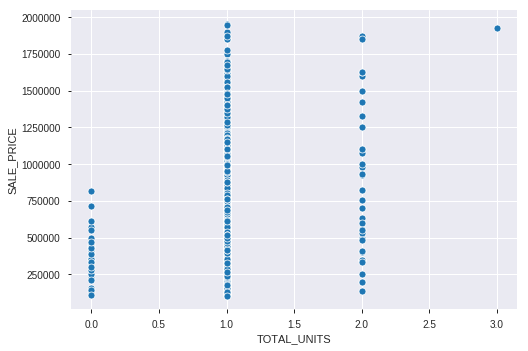

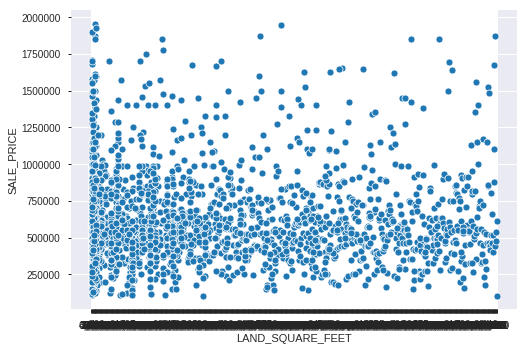

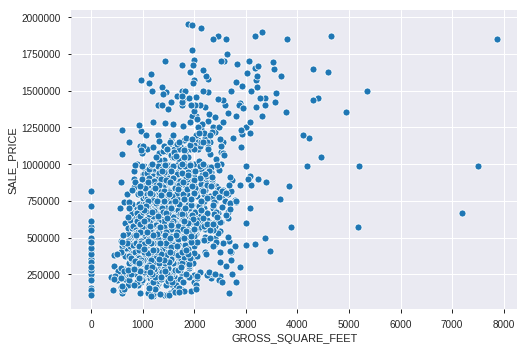

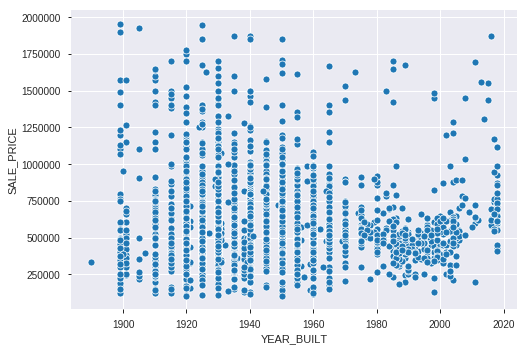

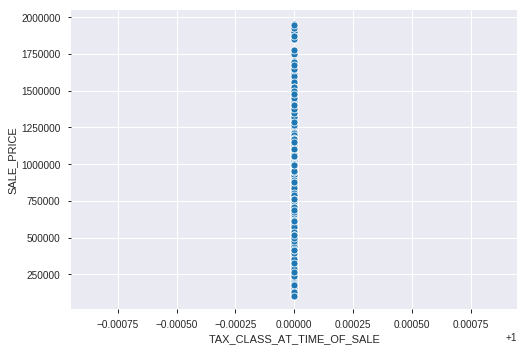

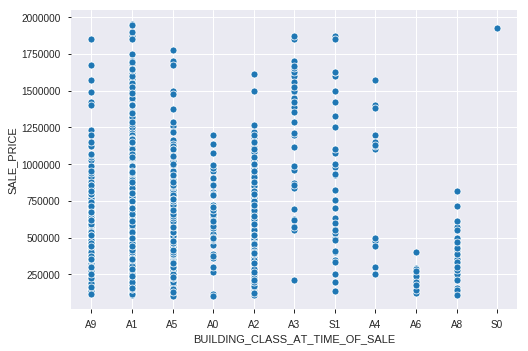

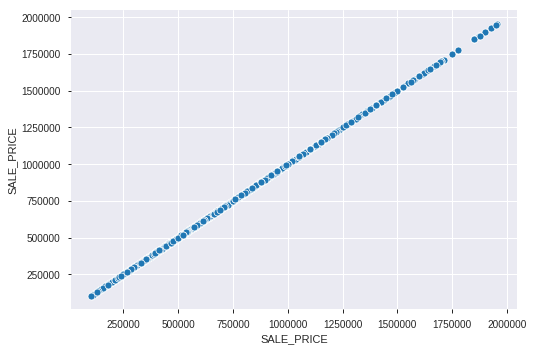

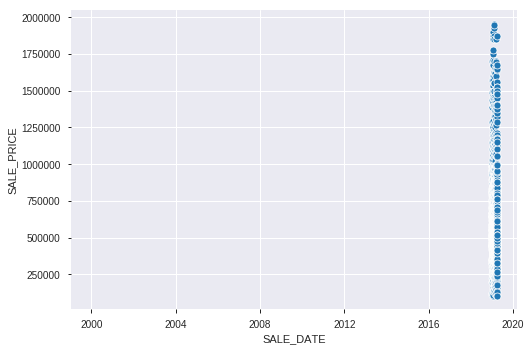

In [0]:
for col in train:
  ax = sns.scatterplot(x=col,y='SALE_PRICE',data=train)
  plt.show()

In [0]:
# Check features for unique values
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaN,NaN
APARTMENT_NUMBER,1,1,RP.,1,NaN,NaN
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaN,NaN
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00
NEIGHBORHOOD,2507,176,FLUSHING-NORTH,77,NaN,NaN
LAND_SQUARE_FEET,2507,887,"4,000",234,NaN,NaN
ADDRESS,2507,2497,118-20 202ND STREET,2,NaN,NaN
